loading the data...


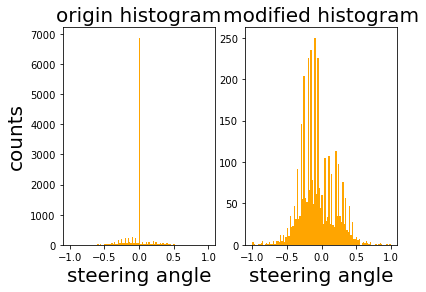

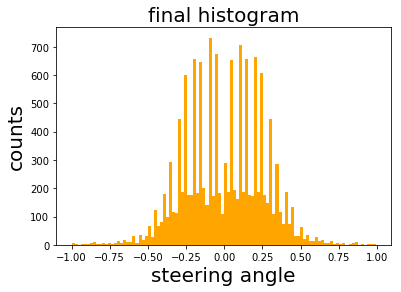

Epoch 1/4
2304/2368 [============================>.] - ETA: 0s - loss: 2.6909

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


2496/2368 [===============================] - 20s - loss: 2.4884 - val_loss: 0.0605
Epoch 2/4
2496/2368 [===============================] - 14s - loss: 0.0789 - val_loss: 0.0458
Epoch 3/4
2496/2368 [===============================] - 15s - loss: 0.0620 - val_loss: 0.0347
Epoch 4/4
2496/2368 [===============================] - 14s - loss: 0.0577 - val_loss: 0.0421


In [2]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


def loadData(basePath):
    
    lines = []
    with open(basePath) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)

    return lines


def balance_data(samples, visulization_flag ,N=60, K=1,  bins=100):

    angles = []
    for line in samples:
        angles.append(float(line[3]))

    n, bins, patches = plt.hist(angles, bins=bins, color= 'orange', linewidth=0.1)
    angles = np.array(angles)
    n = np.array(n)

    idx = n.argsort()[-K:][::-1]    # find the largest K bins
    del_ind = []                    # collect the index which will be removed from the data
    for i in range(K):
        if n[idx[i]] > N:
            ind = np.where((bins[idx[i]]<=angles) & (angles<bins[idx[i]+1]))
            ind = np.ravel(ind)
            np.random.shuffle(ind)
            del_ind.extend(ind[:len(ind)-N])

    # angles = np.delete(angles,del_ind)
    balanced_samples = [v for i, v in enumerate(samples) if i not in del_ind]
    balanced_angles = np.delete(angles,del_ind)

    plt.subplot(1,2,2)
    plt.hist(balanced_angles, bins=bins, color= 'orange', linewidth=0.1)
    plt.title('modified histogram', fontsize=20)
    plt.xlabel('steering angle', fontsize=20)
    plt.ylabel('counts', fontsize=20)

    if visulization_flag:
        plt.figure
        plt.subplot(1,2,1)
        n, bins, patches = plt.hist(angles, bins=bins, color='orange', linewidth=0.1)
        plt.title('origin histogram', fontsize=20)
        plt.xlabel('steering angle', fontsize=20)
        plt.ylabel('counts', fontsize=20)
        plt.show()

        plt.figure
        aa = np.append(balanced_angles, -balanced_angles)
        bb = np.append(aa, aa)
        plt.hist(bb, bins=bins, color='orange', linewidth=0.1)
        plt.title('final histogram', fontsize=20)
        plt.xlabel('steering angle', fontsize=20)
        plt.ylabel('counts', fontsize=20)
        plt.show()

    return balanced_samples

def process_data(samples):
    angles = []
    for line in samples:
        
        angles.append(float(line[3]))
        
        return angles


def brightness_change(image):
    
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = np.random.uniform(0.2,0.8)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)

    return image1


def data_augmentation(images, angles):
    
    augmented_images = []
    augmented_angles = []
    for image, angle in zip(images, angles):

        augmented_images.append(image)
        augmented_angles.append(angle)

        # flip
        flipped_image = cv2.flip(image,1)
        flipped_angle = -1.0 * angle
        augmented_images.append(flipped_image)
        augmented_angles.append(flipped_angle)

        # brightness changes
        image_b1 = brightness_change(image)
        image_b2 = brightness_change(flipped_image)

        # append images
        augmented_images.append(image_b1)
        augmented_angles.append(angle)
        augmented_images.append(image_b2)
        augmented_angles.append(flipped_angle)

    return augmented_images, augmented_angles


def network_model():
    
    model = Sequential()
    model.add(Lambda(lambda x: x / 127.5 - 1., input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70,25),(0,0))))
    model.add(Convolution2D(32,3,3,activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))
    model.add(Convolution2D(64,3,3,activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))
    model.add(Convolution2D(128,3,3, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(256,3,3, activation='relu'))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dense(20))
    model.add(Dense(1))
    return model


def generator(samples, train_flag, batch_size=16):
    
    num_samples = len(samples)
    correction = 0.2  # correction angle used for the left and right images

    while 1:  # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []

            for line in batch_samples:
                
                source_path = line[0]
                filename = source_path.split('\\')[-1]
                c_imagePath = './driving_behavioral/IMG/' + filename
                #print(c_imagePath)
                c_image = cv2.imread(c_imagePath)
                images.append(c_image)
                angle = float(line[3])
                angles.append(angle)

                if train_flag:  # only add left and right images for training data (not for validation)
                    source_path = line[1]
                    filename = source_path.split('\\')[-1]
                    l_imagePath = './driving_behavioral/IMG/' + filename
                    #print(l_imagePath)
                    
                    source_path = line[2]
                    filename = source_path.split('\\')[-1]
                    r_imagePath = './driving_behavioral/IMG/' + filename
                    l_image = cv2.imread(l_imagePath)
                    r_image = cv2.imread(r_imagePath)

                    images.append(l_image)
                    angles.append(angle + correction)
                    images.append(r_image)
                    angles.append(angle - correction)

            # flip image and change the brightness, for each input image, returns other 3 augmented images
            augmented_images, augmented_angles = data_augmentation(images, angles)

            X_train = np.array(augmented_images)
            y_train = np.array(augmented_angles)
            yield shuffle(X_train, y_train)



# load the csv file
basePath = './driving_behavioral/driving_log.csv'
print('loading the data...')
samples = loadData(basePath)


# balance the data with smooth the histogram of steering angles
samples = balance_data(samples, visulization_flag=True)
#print(samples)

angles = process_data(samples)

# split data into training and validation
train_samples, validation_samples = train_test_split(samples, test_size=0.3)

# compile and train the model using the generator function
train_generator = generator(train_samples, train_flag=True, batch_size=16)
validation_generator = generator(validation_samples, train_flag=False, batch_size=16)



# define the network model
model = network_model()
#model.summary()


model.compile(loss='mse', optimizer='adam')

history = model.fit_generator(train_generator, samples_per_epoch=(len(train_samples)//16)*16, validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=4)

model.save('model.h5')
